In [1]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
train = pd.read_json("input/train.json")
target_train=train['is_iceberg']
test = pd.read_json("input/test.json")

In [3]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

In [4]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

In [5]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [6]:
#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [7]:
#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [8]:
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

In [9]:
# Finally create generator
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=30, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [10]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=True)
    model.compile(loss='binary_crossentropy',
                    optimizer=adam,
                    metrics=['accuracy'])
    
#     sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(loss='binary_crossentropy',
#                   optimizer=sgd,
#                   metrics=['accuracy'])
    return model



In [12]:
#def myAngleCV(X_train, X_angle, X_test):
K=10
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
y_test_pred_log = 0
y_train_pred_log=0
y_valid_pred_log = 0.0*target_train
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = target_train[train_idx]
    X_holdout = X_train[test_idx]
    Y_holdout= target_train[test_idx]
    
    #Angle
    X_angle_cv=X_angle[train_idx]
    X_angle_hold=X_angle[test_idx]
    #define file path and get callbacks
    file_path = "%s_aug_model_weights.hdf5"%j
    callbacks = get_callbacks(filepath=file_path, patience=5)
    gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
    galaxyModel= getVggAngleModel()
    histr = galaxyModel.fit_generator(
            gen_flow,
            steps_per_epoch=24,
            epochs=200,
            shuffle=True,
            verbose=1,
            validation_data=([X_holdout,X_angle_hold], Y_holdout),
            callbacks=callbacks)
     #Getting the Best Model
    galaxyModel.load_weights(filepath=file_path)
    #Getting Training Score
    score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #Getting Test Score
    score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    #Getting validation Score.
    pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

    #Getting Test Scores
    temp_test=galaxyModel.predict([X_test, X_test_angle])
    y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

    #Getting Train Scores
    temp_train=galaxyModel.predict([X_train, X_angle])
    y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

y_test_pred_log=y_test_pred_log/K
y_train_pred_log=y_train_pred_log/K

print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
#return y_test_pred_log


===================FOLD= 0
Epoch 1/200
24/24 [==============================] - 18s 739ms/step - loss: 0.7866 - acc: 0.6113 - val_loss: 0.6131 - val_acc: 0.5309
Epoch 2/200
24/24 [==============================] - 14s 590ms/step - loss: 0.6443 - acc: 0.6471 - val_loss: 0.4377 - val_acc: 0.7654
Epoch 3/200
24/24 [==============================] - 14s 588ms/step - loss: 0.4866 - acc: 0.7754 - val_loss: 0.3048 - val_acc: 0.8642
Epoch 4/200
24/24 [==============================] - 14s 593ms/step - loss: 0.3709 - acc: 0.8482 - val_loss: 0.2637 - val_acc: 0.8827
Epoch 5/200
24/24 [==============================] - 14s 594ms/step - loss: 0.3860 - acc: 0.8401 - val_loss: 0.2458 - val_acc: 0.8765
Epoch 6/200
24/24 [==============================] - 12s 514ms/step - loss: 0.3067 - acc: 0.8683 - val_loss: 0.2554 - val_acc: 0.9012
Epoch 7/200
24/24 [==============================] - 12s 510ms/step - loss: 0.2684 - acc: 0.8816 - val_loss: 0.2853 - val_acc: 0.8827
Epoch 8/200
24/24 [===============

Epoch 20/200
24/24 [==============================] - 12s 511ms/step - loss: 0.2104 - acc: 0.9156 - val_loss: 0.2434 - val_acc: 0.9193
Epoch 21/200
24/24 [==============================] - 12s 505ms/step - loss: 0.1745 - acc: 0.9266 - val_loss: 0.2042 - val_acc: 0.8944
Epoch 22/200
24/24 [==============================] - 12s 509ms/step - loss: 0.1924 - acc: 0.9231 - val_loss: 0.1750 - val_acc: 0.9193
Epoch 23/200
24/24 [==============================] - 12s 504ms/step - loss: 0.1724 - acc: 0.9266 - val_loss: 0.2714 - val_acc: 0.9006
Epoch 24/200
24/24 [==============================] - 12s 508ms/step - loss: 0.1952 - acc: 0.9182 - val_loss: 0.2161 - val_acc: 0.9068
Epoch 25/200
24/24 [==============================] - 12s 510ms/step - loss: 0.1850 - acc: 0.9210 - val_loss: 0.1859 - val_acc: 0.9068
Epoch 26/200
24/24 [==============================] - 12s 510ms/step - loss: 0.2080 - acc: 0.9197 - val_loss: 0.1579 - val_acc: 0.9379
Epoch 27/200
24/24 [==============================] - 1

Epoch 81/200
24/24 [==============================] - 12s 502ms/step - loss: 0.0732 - acc: 0.9696 - val_loss: 0.2484 - val_acc: 0.9317
Epoch 82/200
24/24 [==============================] - 12s 502ms/step - loss: 0.0505 - acc: 0.9811 - val_loss: 0.3011 - val_acc: 0.9193
Epoch 83/200
24/24 [==============================] - 12s 501ms/step - loss: 0.0441 - acc: 0.9832 - val_loss: 0.3362 - val_acc: 0.9068
Epoch 84/200
24/24 [==============================] - 12s 502ms/step - loss: 0.0411 - acc: 0.9837 - val_loss: 0.2990 - val_acc: 0.9130
Epoch 85/200
24/24 [==============================] - 12s 503ms/step - loss: 0.0780 - acc: 0.9707 - val_loss: 0.3051 - val_acc: 0.8944
Epoch 86/200
24/24 [==============================] - 12s 502ms/step - loss: 0.1063 - acc: 0.9594 - val_loss: 0.2391 - val_acc: 0.8944
Train loss: 0.0784934860391
Train accuracy: 0.973665973666
Test loss: 0.138775547469
Test accuracy: 0.919254658385

===================FOLD= 3
Epoch 1/200
24/24 [============================

Epoch 55/200
24/24 [==============================] - 12s 507ms/step - loss: 0.1046 - acc: 0.9578 - val_loss: 0.2749 - val_acc: 0.9125
Epoch 56/200
24/24 [==============================] - 12s 509ms/step - loss: 0.1132 - acc: 0.9550 - val_loss: 0.2144 - val_acc: 0.9250
Epoch 57/200
24/24 [==============================] - 12s 506ms/step - loss: 0.1284 - acc: 0.9454 - val_loss: 0.2425 - val_acc: 0.9187
Epoch 58/200
24/24 [==============================] - 12s 506ms/step - loss: 0.1155 - acc: 0.9493 - val_loss: 0.2799 - val_acc: 0.8688
Epoch 59/200
24/24 [==============================] - 12s 510ms/step - loss: 0.0996 - acc: 0.9627 - val_loss: 0.3917 - val_acc: 0.8938
Epoch 60/200
24/24 [==============================] - 12s 507ms/step - loss: 0.0819 - acc: 0.9702 - val_loss: 0.4564 - val_acc: 0.9062
Epoch 61/200
24/24 [==============================] - 12s 505ms/step - loss: 0.0965 - acc: 0.9616 - val_loss: 0.3303 - val_acc: 0.9250
Epoch 62/200
24/24 [==============================] - 1

Train loss: 0.13430626905
Train accuracy: 0.945983379501
Test loss: 0.143599990755
Test accuracy: 0.9625

===================FOLD= 5
Epoch 1/200
24/24 [==============================] - 19s 809ms/step - loss: 0.7476 - acc: 0.6024 - val_loss: 0.6840 - val_acc: 0.7937
Epoch 2/200
24/24 [==============================] - 14s 589ms/step - loss: 0.4803 - acc: 0.7912 - val_loss: 0.5126 - val_acc: 0.7063
Epoch 3/200
24/24 [==============================] - 14s 592ms/step - loss: 0.4563 - acc: 0.7940 - val_loss: 0.2910 - val_acc: 0.8938
Epoch 4/200
24/24 [==============================] - 12s 514ms/step - loss: 0.3335 - acc: 0.8477 - val_loss: 0.3999 - val_acc: 0.8625
Epoch 5/200
24/24 [==============================] - 14s 591ms/step - loss: 0.3640 - acc: 0.8349 - val_loss: 0.2686 - val_acc: 0.9000
Epoch 6/200
24/24 [==============================] - 14s 593ms/step - loss: 0.3352 - acc: 0.8396 - val_loss: 0.2241 - val_acc: 0.9313
Epoch 7/200
24/24 [==============================] - 12s 513ms/

Epoch 61/200
24/24 [==============================] - 12s 506ms/step - loss: 0.0976 - acc: 0.9598 - val_loss: 0.3808 - val_acc: 0.9125
Epoch 62/200
24/24 [==============================] - 12s 504ms/step - loss: 0.0971 - acc: 0.9593 - val_loss: 0.4961 - val_acc: 0.9000
Epoch 63/200
24/24 [==============================] - 12s 506ms/step - loss: 0.0971 - acc: 0.9663 - val_loss: 0.4386 - val_acc: 0.8875
Epoch 64/200
24/24 [==============================] - 12s 503ms/step - loss: 0.0975 - acc: 0.9655 - val_loss: 0.3082 - val_acc: 0.9125
Epoch 65/200
24/24 [==============================] - 12s 509ms/step - loss: 0.0747 - acc: 0.9739 - val_loss: 0.3050 - val_acc: 0.9125
Epoch 66/200
24/24 [==============================] - 12s 503ms/step - loss: 0.0683 - acc: 0.9739 - val_loss: 0.2452 - val_acc: 0.9375
Train loss: 0.0942226873293
Train accuracy: 0.961911357341
Test loss: 0.173995134234
Test accuracy: 0.94375

===================FOLD= 6
Epoch 1/200
24/24 [==============================] - 2

Epoch 55/200
24/24 [==============================] - 12s 508ms/step - loss: 0.0880 - acc: 0.9676 - val_loss: 0.4917 - val_acc: 0.8812
Epoch 56/200
24/24 [==============================] - 12s 510ms/step - loss: 0.0768 - acc: 0.9676 - val_loss: 0.3509 - val_acc: 0.8812
Epoch 57/200
24/24 [==============================] - 12s 506ms/step - loss: 0.0698 - acc: 0.9678 - val_loss: 0.4808 - val_acc: 0.8938
Epoch 58/200
24/24 [==============================] - 12s 507ms/step - loss: 0.0699 - acc: 0.9717 - val_loss: 0.5383 - val_acc: 0.8688
Epoch 59/200
24/24 [==============================] - 12s 509ms/step - loss: 0.1160 - acc: 0.9616 - val_loss: 0.3285 - val_acc: 0.8812
Epoch 60/200
24/24 [==============================] - 12s 510ms/step - loss: 0.0874 - acc: 0.9678 - val_loss: 0.3639 - val_acc: 0.9000
Epoch 61/200
24/24 [==============================] - 12s 505ms/step - loss: 0.0789 - acc: 0.9728 - val_loss: 0.3813 - val_acc: 0.8500
Epoch 62/200
24/24 [==============================] - 1

Epoch 48/200
24/24 [==============================] - 12s 509ms/step - loss: 0.1022 - acc: 0.9534 - val_loss: 0.1829 - val_acc: 0.9437
Epoch 49/200
24/24 [==============================] - 12s 503ms/step - loss: 0.1058 - acc: 0.9585 - val_loss: 0.2258 - val_acc: 0.9000
Epoch 50/200
24/24 [==============================] - 12s 506ms/step - loss: 0.1163 - acc: 0.9575 - val_loss: 0.2177 - val_acc: 0.8688
Epoch 51/200
24/24 [==============================] - 12s 505ms/step - loss: 0.0944 - acc: 0.9590 - val_loss: 0.1975 - val_acc: 0.9250
Epoch 52/200
24/24 [==============================] - 12s 506ms/step - loss: 0.0986 - acc: 0.9580 - val_loss: 0.1960 - val_acc: 0.9437
Epoch 53/200
24/24 [==============================] - 12s 510ms/step - loss: 0.1660 - acc: 0.9336 - val_loss: 0.2705 - val_acc: 0.8625
Epoch 54/200
24/24 [==============================] - 12s 504ms/step - loss: 0.1337 - acc: 0.9539 - val_loss: 0.1856 - val_acc: 0.9313
Epoch 55/200
24/24 [==============================] - 1

Epoch 17/200
24/24 [==============================] - 12s 511ms/step - loss: 0.2209 - acc: 0.9158 - val_loss: 0.2696 - val_acc: 0.8875
Epoch 18/200
24/24 [==============================] - 12s 511ms/step - loss: 0.1924 - acc: 0.9182 - val_loss: 0.2484 - val_acc: 0.9062
Epoch 19/200
24/24 [==============================] - 12s 512ms/step - loss: 0.1945 - acc: 0.9267 - val_loss: 0.2170 - val_acc: 0.9313
Epoch 20/200
24/24 [==============================] - 12s 510ms/step - loss: 0.1889 - acc: 0.9235 - val_loss: 0.2095 - val_acc: 0.9187
Epoch 21/200
24/24 [==============================] - 12s 510ms/step - loss: 0.1987 - acc: 0.9150 - val_loss: 0.2163 - val_acc: 0.9250
Epoch 22/200
24/24 [==============================] - 14s 590ms/step - loss: 0.1728 - acc: 0.9332 - val_loss: 0.1911 - val_acc: 0.9187
Epoch 23/200
24/24 [==============================] - 12s 502ms/step - loss: 0.1780 - acc: 0.9281 - val_loss: 0.2753 - val_acc: 0.8813
Epoch 24/200
24/24 [==============================] - 1

In [13]:
#preds=myAngleCV(X_train, X_angle, X_test)
preds = y_test_pred_log

In [14]:
# Submission to kaggle
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub_Adam_10folds_amsgrad_0001_30p.csv', index=False)

dict_keys(['val_acc', 'val_loss', 'loss', 'acc'])


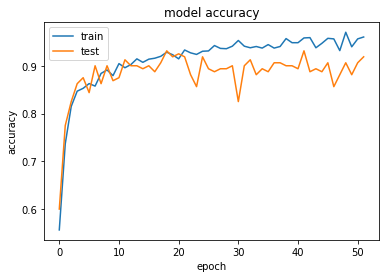

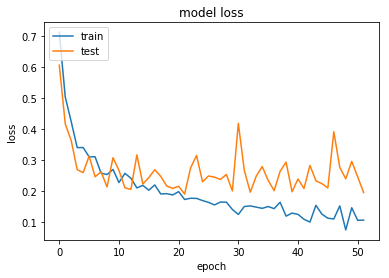

In [15]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

In [16]:
import matplotlib.image as mpimg

min1 = np.min(X_holdout)
max1 = np.max(X_holdout)
diff1 = max1 - min1
my_sum = lambda x: (x - min1)/diff1

X_holdout2 = my_sum(X_holdout)

In [17]:
Y_holdout

13      1
14      0
38      1
43      0
44      0
80      0
104     1
127     0
137     0
138     1
141     1
167     1
195     1
199     0
207     1
212     0
213     1
221     0
240     0
256     0
267     1
274     1
276     1
285     1
290     0
294     0
300     1
307     1
311     1
318     1
       ..
1363    1
1364    0
1373    1
1380    1
1394    0
1411    0
1435    0
1440    1
1445    1
1447    1
1460    1
1470    0
1488    0
1495    0
1504    1
1516    0
1525    0
1533    0
1537    0
1539    0
1541    0
1542    0
1549    0
1552    0
1559    0
1566    0
1567    0
1577    0
1590    0
1602    0
Name: is_iceberg, Length: 160, dtype: int64

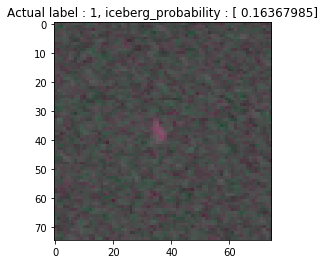

In [18]:
plt.imshow(X_holdout2[0], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[13])+ ","+" iceberg_probability : "+str(pred_valid[0])
plt.title(tl)

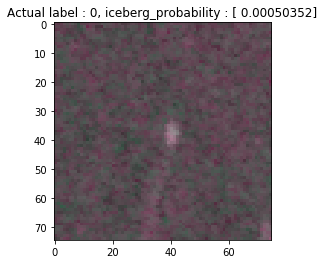

In [19]:
plt.imshow(X_holdout2[1], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[14])+ ","+" iceberg_probability : "+str(pred_valid[1])
plt.title(tl)

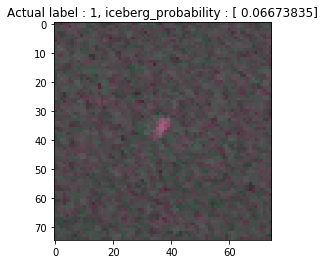

In [20]:
plt.imshow(X_holdout2[2], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[38])+ ","+" iceberg_probability : "+str(pred_valid[2])
plt.title(tl)

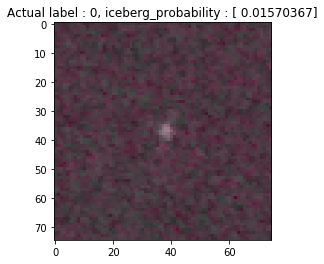

In [21]:
plt.imshow(X_holdout2[3], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[43])+ ","+" iceberg_probability : "+str(pred_valid[3])
plt.title(tl)

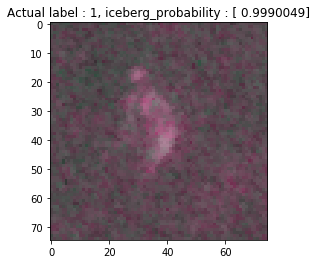

In [22]:
plt.imshow(X_holdout2[6], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[104])+ ","+" iceberg_probability : "+str(pred_valid[6])
plt.title(tl)

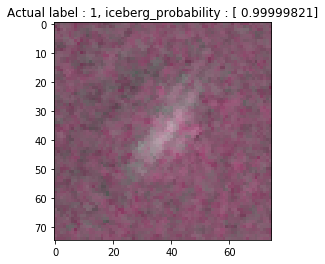

In [23]:
plt.imshow(X_holdout2[9], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[138])+ ","+" iceberg_probability : "+str(pred_valid[9])
plt.title(tl)

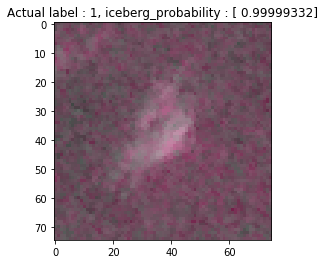

In [24]:
plt.imshow(X_holdout2[10], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[141])+ ","+" iceberg_probability : "+str(pred_valid[10])
plt.title(tl)

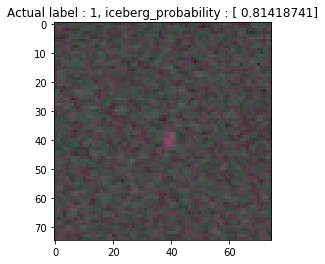

In [25]:
plt.imshow(X_holdout2[11], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[167])+ ","+" iceberg_probability : "+str(pred_valid[11])
plt.title(tl)

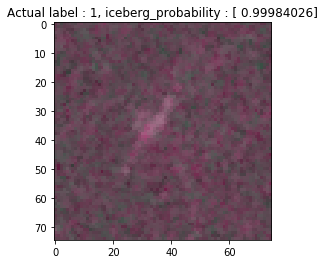

In [26]:
plt.imshow(X_holdout2[12], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[195])+ ","+" iceberg_probability : "+str(pred_valid[12])
plt.title(tl)

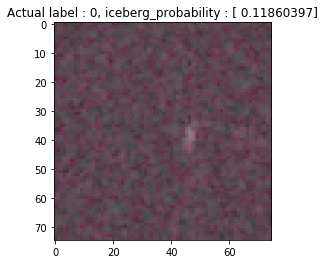

In [27]:
plt.imshow(X_holdout2[13], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[199])+ ","+" iceberg_probability : "+str(pred_valid[13])
plt.title(tl)